# Simulation MPQC

### Same configuration as the paper shown
We consider Single qubit unitary as "op", number of blocks is equal to the number of qubits, exact same quantum circuit as the Fig 1 c) in the paper "Taming Barren Plateaus in Arbitrary Parameterized Quantum Circuits Without Sacrificing Expressibility".


=== Running Variance Analysis ===

>>> Starting Variance Experiment (Samples per point: 200)
------------------------------------------------------------
N=3, Depth=3 | Var(Orig): 3.6965e-01 | Var(MPQC): 3.8552e-01
N=4, Depth=4 | Var(Orig): 3.2020e-01 | Var(MPQC): 5.1655e-01
N=5, Depth=5 | Var(Orig): 2.6759e-01 | Var(MPQC): 4.0734e-01
N=6, Depth=6 | Var(Orig): 1.7049e-01 | Var(MPQC): 5.6357e-01
N=7, Depth=7 | Var(Orig): 1.1502e-01 | Var(MPQC): 6.4519e-01
N=8, Depth=8 | Var(Orig): 7.3771e-02 | Var(MPQC): 5.4708e-01
N=9, Depth=9 | Var(Orig): 5.0829e-02 | Var(MPQC): 4.1795e-01
N=10, Depth=10 | Var(Orig): 3.4611e-02 | Var(MPQC): 6.9422e-01

>>> Result plot saved as 'variance_scaling_log.png'


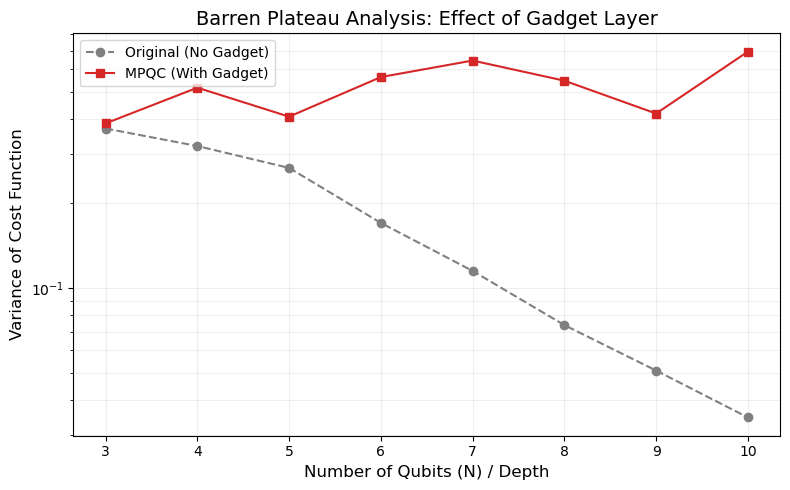

In [7]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. Elementary Gate Definitions
#    - These define the specific gate decompositions shown in your image.
# =============================================================================

def Green_Unit(wires, params):
    """
    Single-qubit unitary block: R_Y(t1) R_Z(t2) R_Y(t3).
    Requires 3 parameters.
    """
    qml.RY(params[0], wires=wires)
    qml.RZ(params[1], wires=wires)
    qml.RY(params[2], wires=wires)

def Blue_Unit(wires, params):
    """
    Two-qubit unitary block acting on wires[0] and wires[1].
    Based on the complex decomposition provided in the image.
    Requires 12 parameters.
    """
    q0, q1 = wires[0], wires[1]

    # 1. Green Unit on q0
    Green_Unit(q0, params[0:3])

    # 2. CNOT (Control q0, Target q1)
    qml.CNOT(wires=[q0, q1])

    # 3. Intermediate Rotations on q0
    qml.RY(params[3], wires=q0)
    qml.RZ(params[4], wires=q0)

    # 4. CNOT (Control q1, Target q0)
    qml.CNOT(wires=[q1, q0])

    # 5. Intermediate Rotation on q0
    qml.RY(params[5], wires=q0)

    # 6. CNOT (Control q0, Target q1)
    qml.CNOT(wires=[q0, q1])

    # 7. Green Unit on q0
    Green_Unit(q0, params[6:9])

    # 8. Green Unit on q1
    Green_Unit(q1, params[9:12])

def MPQC_Layer(wires, params, start_index):
    """
    Applies a layer of Blue Units.
    
    Args:
        wires: List of qubit indices.
        params: Parameters for this layer.
        start_index: 0 for Block 1 (pairs 0-1, 2-3...), 1 for Block 2 (pairs 1-2, 3-4...).
    """
    n_qubits = len(wires)
    n_blue_params = 12

    # Calculate how many Blue Units fit in this layer
    n_pairs = (n_qubits - start_index) // 2

    cursor = 0
    for i in range(n_pairs):
        w1 = start_index + i * 2
        w2 = w1 + 1

        # Slice parameters for one unit
        unit_params = params[cursor : cursor + n_blue_params]

        # Apply the unit
        Blue_Unit([wires[w1], wires[w2]], unit_params)

        cursor += n_blue_params

# =============================================================================
# 2. Gadget Layer Definition
#    - Used for the Hybrid Circuit (MPQC with Gadget).
# =============================================================================

def apply_U(wire, phi, psi):
    """Helper gate U applied to Ancilla qubits."""
    qml.RZ(phi, wires=wire)
    qml.RY(2 * psi, wires=wire)

def Gadget_Layer(data_wires, anc_wires, interaction_params, u_params):
    """
    Applies the Gadget Layer:
    1. U(phi, psi) on Ancilla.
    2. Ising XX, YY, ZZ coupling between Ancilla and Data qubits.
    """
    phi, psi = u_params[0], u_params[1]

    for i in range(len(data_wires)):
        d_wire = data_wires[i]
        a_wire = anc_wires[i]

        # Apply U on Ancilla
        apply_U(a_wire, phi, psi)

        # Apply Interaction (Ancilla <-> Data)
        # interaction_params[i] contains [theta_xx, theta_yy, theta_zz]
        qml.IsingXX(interaction_params[i, 0], wires=[a_wire, d_wire])
        qml.IsingYY(interaction_params[i, 1], wires=[a_wire, d_wire])
        qml.IsingZZ(interaction_params[i, 2], wires=[a_wire, d_wire])

def get_mpqc_param_count(n_qubits, depth):
    """Calculates the total number of parameters required for the MPQC blocks."""
    total = 0
    for d in range(depth):
        start_index = d % 2
        n_pairs = (n_qubits - start_index) // 2
        total += n_pairs * 12
    return total

# =============================================================================
# 3. Dynamic Circuit Builders
#    - Creates QNodes dynamically based on the number of qubits N.
# =============================================================================

def get_cost_functions(n_data):
    """
    Returns two QNodes for a specific number of data qubits (N):
    1. circuit_orig: Original PQC (No Gadget).
    2. circuit_mpqc: Hybrid PQC (With Gadget inserted before the last block).
    
    Constraint: Depth = N.
    """
    depth = n_data

    # --- 1. Original Circuit (No Gadget) ---
    dev_orig = qml.device("default.qubit", wires=n_data)

    @qml.qnode(dev_orig)
    def circuit_no_gadget(params):
        wires = range(n_data)
        cursor = 0

        for d in range(depth):
            start_index = d % 2 # Alternating connectivity

            # Calculate parameters needed for this layer
            n_pairs = (n_data - start_index) // 2
            n_layer_params = n_pairs * 12

            # Apply MPQC Layer
            layer_params = params[cursor : cursor + n_layer_params]
            MPQC_Layer(wires, layer_params, start_index)
            cursor += n_layer_params

        # Measurement: Sum of PauliZ on all wires
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_data)]))

    # --- 2. Hybrid MPQC Circuit (With Gadget) ---
    # Requires 2*N wires (Data + Ancilla)
    n_total = 2 * n_data
    dev_mpqc = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev_mpqc)
    def circuit_with_gadget(mpqc_params, gadget_params, u_params):
        data_wires = list(range(n_data))
        anc_wires = list(range(n_data, n_total))

        cursor = 0

        for d in range(depth):
            # === Insert Gadget before the LAST block ===
            if d == depth - 1:
                # Visual barrier
                qml.Barrier(wires=range(n_total))

                # Apply Gadget
                reshaped_gadget = gadget_params.reshape((n_data, 3))
                Gadget_Layer(data_wires, anc_wires, reshaped_gadget, u_params)

                # Visual barrier
                qml.Barrier(wires=range(n_total))

            # === Standard MPQC Block ===
            start_index = d % 2
            n_pairs = (n_data - start_index) // 2
            n_layer_params = n_pairs * 12

            layer_params = mpqc_params[cursor : cursor + n_layer_params]
            MPQC_Layer(data_wires, layer_params, start_index)
            cursor += n_layer_params

        # Measurement: Sum of PauliZ on Data wires only
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in data_wires]))

    return circuit_no_gadget, circuit_with_gadget

# =============================================================================
# 4. Experiment Runner (Variance Calculation)
# =============================================================================

def run_variance_experiment(n_qubit_list, n_samples=100):
    """
    Runs the sampling experiment to calculate Var(Cost) for different N.
    """
    var_orig_list = []
    var_mpqc_list = []

    print(f"\n>>> Starting Variance Experiment (Samples per point: {n_samples})")
    print("-" * 60)

    for n in n_qubit_list:
        depth = n

        # Get QNodes for current N
        circuit_orig, circuit_mpqc = get_cost_functions(n)

        # Calculate required parameter counts
        n_mpqc_params = get_mpqc_param_count(n, depth)
        n_gadget_params = n * 3
        n_u_params = 2

        # --- Sampling Original Circuit ---
        losses_orig = []
        for _ in range(n_samples):
            theta = 2 * np.pi * np.random.rand(n_mpqc_params)
            val = circuit_orig(theta)
            losses_orig.append(val)

        # --- Sampling MPQC Circuit (Hybrid) ---
        losses_mpqc = []
        for _ in range(n_samples):
            theta_m = 2 * np.pi * np.random.rand(n_mpqc_params)
            theta_g = 2 * np.pi * np.random.rand(n_gadget_params)
            theta_u = 2 * np.pi * np.random.rand(n_u_params)
            val = circuit_mpqc(theta_m, theta_g, theta_u)
            losses_mpqc.append(val)

        # Calculate Variances
        v_orig = np.var(losses_orig)
        v_mpqc = np.var(losses_mpqc)

        var_orig_list.append(v_orig)
        var_mpqc_list.append(v_mpqc)

        print(f"N={n}, Depth={depth} | Var(Orig): {v_orig:.4e} | Var(MPQC): {v_mpqc:.4e}")

    return var_orig_list, var_mpqc_list

# =============================================================================
# 5. Plotting Helper
# =============================================================================

def plot_results(n_qubit_list, var_orig, var_mpqc):
    plt.figure(figsize=(8, 5))

    plt.plot(n_qubit_list, var_orig, 'o--', color='grey', label="Original (No Gadget)")
    plt.plot(n_qubit_list, var_mpqc, 's-', color='#d62728', label="MPQC (With Gadget)")

    plt.xlabel("Number of Qubits (N) / Depth", fontsize=12)
    plt.ylabel("Variance of Cost Function", fontsize=12)
    plt.yscale("log") # Log scale to detect exponential decay (Barren Plateaus)
    plt.title("Barren Plateau Analysis: Effect of Gadget Layer", fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    filename = "variance_scaling_log.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"\n>>> Result plot saved as '{filename}'")
    plt.show()

# =============================================================================
# 6. Main Execution
# =============================================================================

if __name__ == "__main__":

    # --- PART B: Run Variance Experiment ---
    print("\n=== Running Variance Analysis ===")

    # List of N values to test. 
    # Note: Simulation time grows exponentially. Keep N small for local testing.
    N_LIST = [3,4,5,6,7,8,9,10]

    # Run experiment
    v_orig, v_mpqc = run_variance_experiment(N_LIST, n_samples=200)

    # Plot results
    plot_results(N_LIST, v_orig, v_mpqc)


=== Generating Circuit Diagrams (Visualization) ===


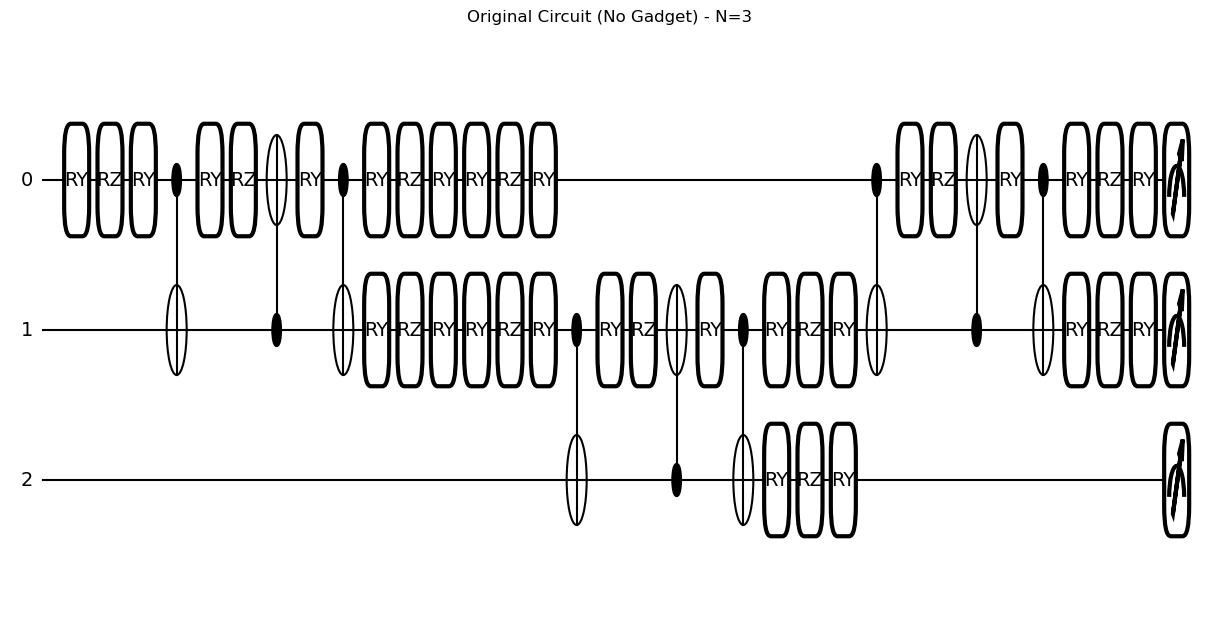

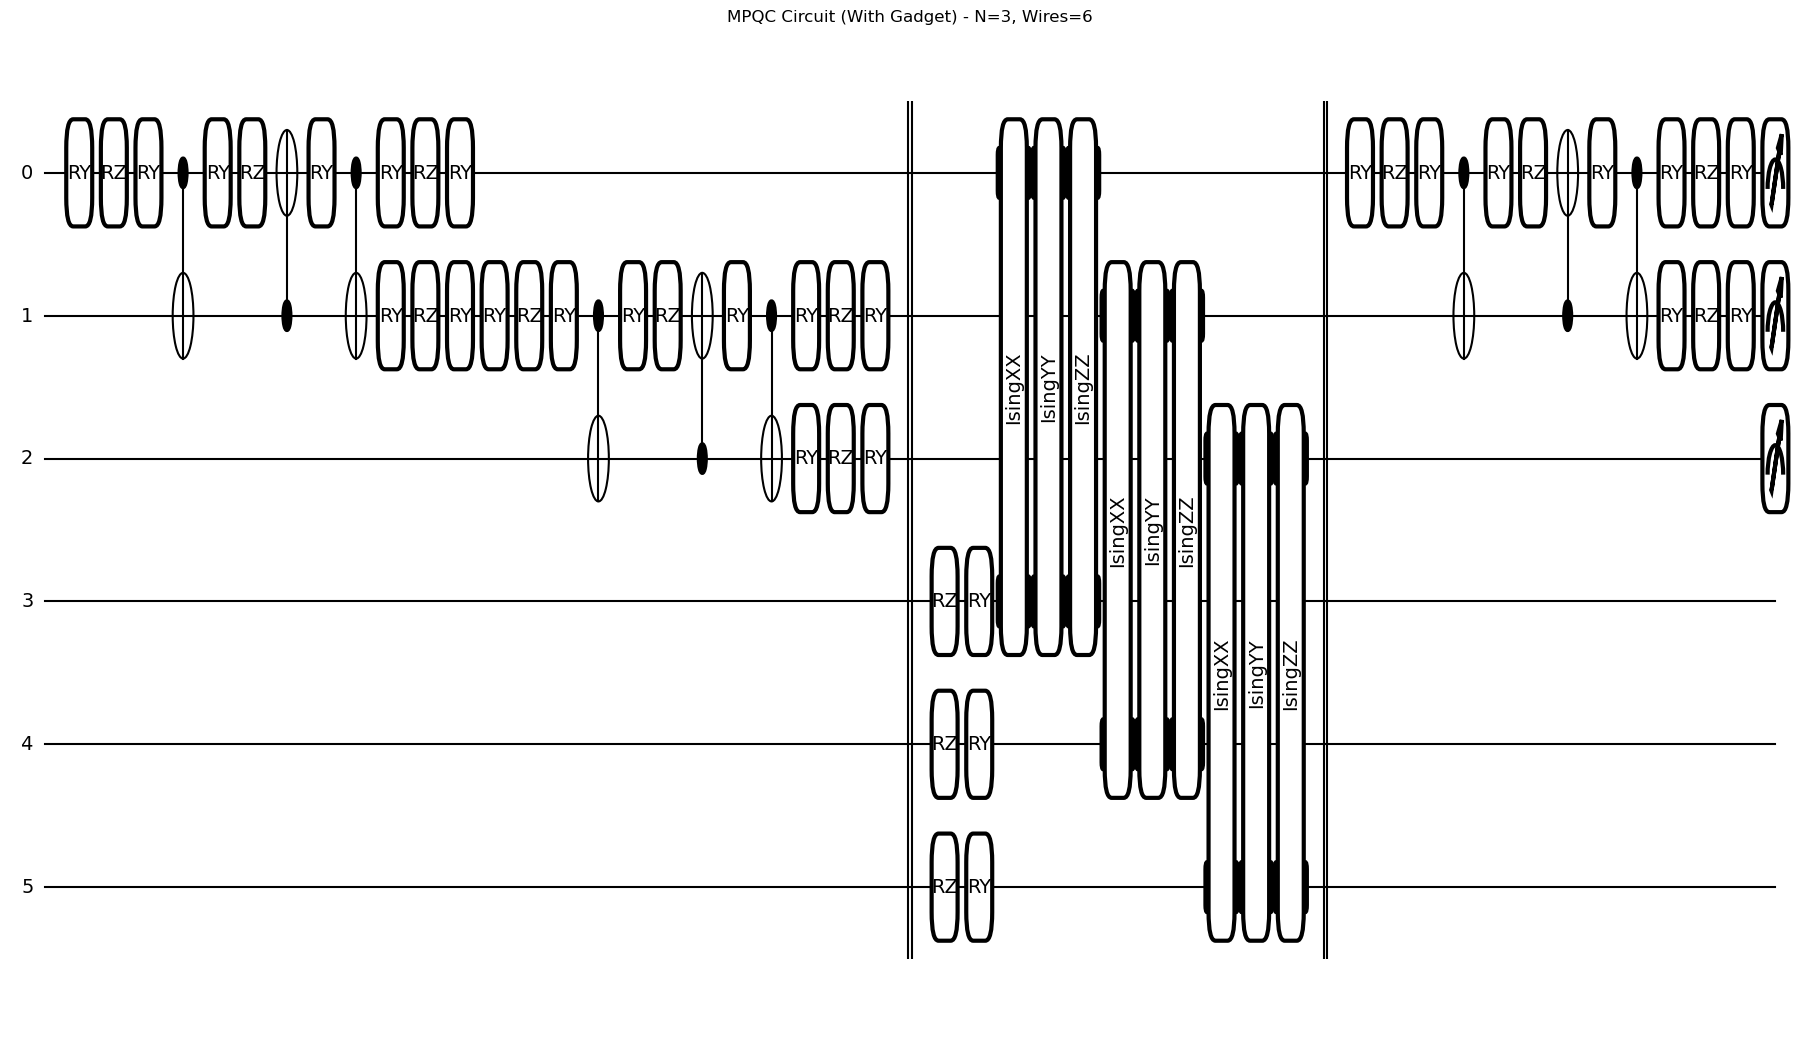

In [5]:
    # --- PART A: Visualize Circuit Structures (N=4) ---
print("\n=== Generating Circuit Diagrams (Visualization) ===")

N_vis = 3
Depth_vis = 3
circ_orig, circ_mpqc = get_cost_functions(N_vis)

# Generate dummy parameters for drawing
n_mpqc_p = get_mpqc_param_count(N_vis, Depth_vis)
n_gadg_p = N_vis * 3
n_u_p = 2

np.random.seed(42)
theta_m = np.random.randn(n_mpqc_p)
theta_g = np.random.randn(n_gadg_p)
theta_u = np.random.randn(n_u_p)


# Draw Original
fig1, ax1 = qml.draw_mpl(circ_orig)(theta_m)
fig1.set_size_inches(12, 6)
plt.title(f"Original Circuit (No Gadget) - N={N_vis}")
# fig1.savefig("circuit_original.png", dpi=300, bbox_inches="tight")
# print("Saved 'circuit_original.png'")
plt.show() # Uncomment to display interactive window
plt.close(fig1)

# Draw MPQC (Hybrid)
fig2, ax2 = qml.draw_mpl(circ_mpqc)(theta_m, theta_g, theta_u)
fig2.set_size_inches(18, 10)
plt.title(f"MPQC Circuit (With Gadget) - N={N_vis}, Wires={2*N_vis}")
# fig2.savefig("circuit_hybrid.png", dpi=300, bbox_inches="tight")
# print("Saved 'circuit_hybrid.png'")
plt.show() # Uncomment to display interactive window
plt.close(fig2)

In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. Circuit Layer Definitions
# =============================================================================

def MPQC_Layer(wires, params):
    """
    Represents one 'Block' of the variational circuit.
    
    According to your request, this is now a single layer of 
    StronglyEntanglingLayers.
    
    Args:
        wires: The wires to apply the layer on.
        params: A flat array of parameters. 
                Expected size: len(wires) * 3.
    """
    n_wires = len(wires)

    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3).
    # Here we apply 1 layer per block.
    reshaped_params = params.reshape((1, n_wires, 3))

    # We use 'ranges=[1]' to simulate nearest-neighbor entanglement 
    # similar to the previous architecture, or leave default. 
    # Standard StronglyEntangling uses ranges=[1] for 1 layer usually.
    qml.StronglyEntanglingLayers(reshaped_params, wires=wires)


# =============================================================================
# 2. Gadget Layer Definitions
#    (Unchanged from previous version)
# =============================================================================

def apply_U(wire, phi, psi):
    """Helper gate U applied to Ancilla qubits."""
    qml.RZ(phi, wires=wire)
    qml.RY(2 * psi, wires=wire)

def Gadget_Layer(data_wires, anc_wires, interaction_params, u_params):
    """
    Applies the Gadget Layer:
    1. U(phi, psi) on Ancilla.
    2. Ising XX, YY, ZZ coupling between Ancilla and Data qubits.
    """
    phi, psi = u_params[0], u_params[1]

    for i in range(len(data_wires)):
        d_wire = data_wires[i]
        a_wire = anc_wires[i]

        # Apply U on Ancilla
        apply_U(a_wire, phi, psi)

        # Apply Interaction (Ancilla <-> Data)
        # interaction_params[i] contains [theta_xx, theta_yy, theta_zz]
        qml.IsingXX(interaction_params[i, 0], wires=[a_wire, d_wire])
        qml.IsingYY(interaction_params[i, 1], wires=[a_wire, d_wire])
        qml.IsingZZ(interaction_params[i, 2], wires=[a_wire, d_wire])

def get_mpqc_param_count(n_qubits, depth):
    """
    Calculates the total parameters for the MPQC blocks.
    StronglyEntanglingLayers (1 layer) needs N * 3 parameters.
    Total = Depth * N * 3.
    """
    return depth * n_qubits * 3

# =============================================================================
# 3. Dynamic Circuit Builders
# =============================================================================

def get_cost_functions(n_data):
    """
    Returns two QNodes for a specific number of data qubits (N):
    1. circuit_orig: Original PQC (No Gadget).
    2. circuit_mpqc: Hybrid PQC (With Gadget inserted before the last block).
    
    Constraint: Depth = n_data.
    """
    depth = n_data

    # --- 1. Original Circuit (No Gadget) ---
    dev_orig = qml.device("default.qubit", wires=n_data)

    @qml.qnode(dev_orig)
    def circuit_no_gadget(params):
        wires = range(n_data)
        cursor = 0

        # Each layer in the loop is one MPQC_Layer (StronglyEntangling)
        for d in range(depth):

            # Calculate parameters needed for this layer (N * 3)
            n_layer_params = n_data * 3

            # Slice parameters
            layer_params = params[cursor : cursor + n_layer_params]

            # Apply Layer
            MPQC_Layer(wires, layer_params)

            cursor += n_layer_params

        # Measurement: Sum of PauliZ on all wires
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_data)]))

    # --- 2. Hybrid MPQC Circuit (With Gadget) ---
    # Requires 2*N wires (Data + Ancilla)
    n_total = 2 * n_data
    dev_mpqc = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev_mpqc)
    def circuit_with_gadget(mpqc_params, gadget_params, u_params):
        data_wires = list(range(n_data))
        anc_wires = list(range(n_data, n_total))

        cursor = 0

        for d in range(depth):
            # === Insert Gadget before the LAST block ===
            if d == depth - 1:
                # Visual barrier
                qml.Barrier(wires=range(n_total))

                # Apply Gadget
                reshaped_gadget = gadget_params.reshape((n_data, 3))
                Gadget_Layer(data_wires, anc_wires, reshaped_gadget, u_params)

                # Visual barrier
                qml.Barrier(wires=range(n_total))

            # === Standard MPQC Block (StronglyEntangling) ===
            n_layer_params = n_data * 3
            layer_params = mpqc_params[cursor : cursor + n_layer_params]

            # Note: MPQC_Layer applies only to Data Wires
            MPQC_Layer(data_wires, layer_params)

            cursor += n_layer_params

        # Measurement: Sum of PauliZ on Data wires only
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in data_wires]))

    return circuit_no_gadget, circuit_with_gadget

# =============================================================================
# 4. Experiment Runner (Variance Calculation)
# =============================================================================

def run_variance_experiment(n_qubit_list, n_samples=100):
    """
    Runs the sampling experiment to calculate Var(Cost) for different N.
    """
    var_orig_list = []
    var_mpqc_list = []

    print(f"\n>>> Starting Variance Experiment (Samples per point: {n_samples})")
    print("-" * 70)

    for n in n_qubit_list:
        depth = n

        # Get QNodes for current N
        circuit_orig, circuit_mpqc = get_cost_functions(n)

        # Calculate required parameter counts
        n_mpqc_params = get_mpqc_param_count(n, depth)
        n_gadget_params = n * 3
        n_u_params = 2

        # --- Sampling Original Circuit ---
        losses_orig = []
        for _ in range(n_samples):
            # Random parameters [0, 2pi]
            theta = 2 * np.pi * np.random.rand(n_mpqc_params)
            val = circuit_orig(theta)
            losses_orig.append(val)

        # --- Sampling MPQC Circuit (Hybrid) ---
        losses_mpqc = []
        for _ in range(n_samples):
            theta_m = 2 * np.pi * np.random.rand(n_mpqc_params)
            theta_g = 2 * np.pi * np.random.rand(n_gadget_params)
            theta_u = 2 * np.pi * np.random.rand(n_u_params)
            val = circuit_mpqc(theta_m, theta_g, theta_u)
            losses_mpqc.append(val)

        # Calculate Variances
        v_orig = np.var(losses_orig)
        v_mpqc = np.var(losses_mpqc)

        var_orig_list.append(v_orig)
        var_mpqc_list.append(v_mpqc)

        print(f"N={n}, Depth={depth} | Var(Orig): {v_orig:.4e} | Var(MPQC): {v_mpqc:.4e}")

    return var_orig_list, var_mpqc_list

# =============================================================================
# 5. Plotting Helper
# =============================================================================

def plot_results(n_qubit_list, var_orig, var_mpqc):
    plt.figure(figsize=(8, 5))

    plt.plot(n_qubit_list, var_orig, 'o--', color='grey', label="Original (StronglyEntangling)")
    plt.plot(n_qubit_list, var_mpqc, 's-', color='#d62728', label="MPQC (Hybrid + Gadget)")

    plt.xlabel("Number of Qubits (N) / Depth", fontsize=12)
    plt.ylabel("Variance of Cost Function", fontsize=12)
    plt.yscale("log") # Log scale is crucial for Barren Plateau analysis
    plt.title("Barren Plateau Analysis: StronglyEntangling + Gadget", fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    filename = "variance_scaling_strong_ent.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"\n>>> Result plot saved as '{filename}'")
    plt.show()

# =============================================================================
# 6. Main Execution
# =============================================================================

if __name__ == "__main__":

    # --- PART A: Visualize Circuit Structures (N=4) ---
    print("\n=== PART A: Generating Circuit Diagrams (Visualization) ===")

    N_vis = 4
    Depth_vis = 4
    circ_orig, circ_mpqc = get_cost_functions(N_vis)

    # Generate dummy parameters for drawing
    n_mpqc_p = get_mpqc_param_count(N_vis, Depth_vis)
    n_gadg_p = N_vis * 3
    n_u_p = 2

    np.random.seed(42)
    theta_m = np.random.randn(n_mpqc_p)
    theta_g = np.random.randn(n_gadg_p)
    theta_u = np.random.randn(n_u_p)

    # Draw Original
    try:
        fig1, ax1 = qml.draw_mpl(circ_orig, decimals=2)(theta_m)
        fig1.set_size_inches(12, 6)
        plt.title(f"Original Circuit (StronglyEntangling) - N={N_vis}")
        fig1.savefig("circuit_original_se.png", dpi=300, bbox_inches="tight")
        print("Saved 'circuit_original_se.png'")
        plt.close(fig1)
    except Exception as e:
        print(f"Skipping mpl drawing for Original: {e}")

    # Draw MPQC (Hybrid)
    try:
        fig2, ax2 = qml.draw_mpl(circ_mpqc, decimals=2)(theta_m, theta_g, theta_u)
        fig2.set_size_inches(18, 10)
        plt.title(f"MPQC Circuit (StronglyEntangling + Gadget) - N={N_vis}")
        fig2.savefig("circuit_hybrid_se.png", dpi=300, bbox_inches="tight")
        print("Saved 'circuit_hybrid_se.png'")
        plt.close(fig2)
    except Exception as e:
        print(f"Skipping mpl drawing for MPQC: {e}")

    # --- PART B: Run Variance Experiment ---
    print("\n=== PART B: Running Variance Analysis ===")

    # Testing with N = 2, 4, 6 (Scales exponentially, keep N low for fast test)
    N_LIST = [2, 4, 6]

    # Run experiment
    v_orig, v_mpqc = run_variance_experiment(N_LIST, n_samples=50)

    # Plot results
    plot_results(N_LIST, v_orig, v_mpqc)